# **Super-Resolution for Image Classification Data Preprocessing / Augmentation**

## Import Library

In [1]:
import random

import numpy as np

import torch
from torch import nn
import torch.nn.functional as F

from torchsummary import summary

## Fix Seed

In [2]:
def fix_seed(seed) :
  # Fix Seed
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

## Create AverageMeter Class



In [3]:
class AverageMeter(object) :
  def __init__(self) :
    self.reset()

  def reset(self) :
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1) :
    self.val = val
    self.sum += val*n
    self.count += n
    self.avg = self.sum/self.count

## VGG Model Components

In [4]:
########## Conv-BN-ReLU-Block Implementation ##########
class ConvBlockwithBN(nn.Module) :
  def __init__(self, in_channels, out_channels, num_layers) :
    super().__init__()
    # Create Convolutional Layer Instance

    if num_layers == 2 :
      self.conv_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(out_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(out_channels),
                                      nn.ReLU(inplace=True))
    elif num_layers == 3 :
      self.conv_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(out_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(out_channels),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
                                      nn.BatchNorm2d(out_channels),
                                      nn.ReLU(inplace=True))

  def forward(self, x) :
      return self.conv_block(x)

In [5]:
########## Linear-Dropout-ReLU-Block Implementation ##########
class LinearBlockwithDropout(nn.Module) :
  def __init__(self, in_channels, num_classes, p) :
    super().__init__()
    # Create Linear Layer Instance

    self.linear_block = nn.Sequential(nn.Linear(in_channels, in_channels),
                                      nn.Dropout(p),
                                      nn.ReLU(inplace=True),
                                      nn.Linear(in_channels, in_channels),
                                      nn.Dropout(p),
                                      nn.ReLU(inplace=True),
                                      nn.Linear(in_channels, num_classes))

  def forward(self, x) :
      return self.linear_block(x)

## VGG16 Model

In [6]:
########## VGG-16-BN-Like Model Implementation ##########
class VGG16withBN(nn.Module) :
  def __init__(self, img_channels, width, num_classes, p) :
    super().__init__()

    # Create Convolutional Layer Instance
    self.conv_block_1 = ConvBlockwithBN(img_channels, width, num_layers=2)
    self.conv_block_2 = ConvBlockwithBN(width, width*2, num_layers=2)
    self.conv_block_3 = ConvBlockwithBN(width*2, width*4, num_layers=3)
    self.conv_block_4 = ConvBlockwithBN(width*4, width*4, num_layers=3)
    self.conv_block_5 = ConvBlockwithBN(width*4, width*4, num_layers=3)

    # Create Classifier Layer Instance
    self.classifier = LinearBlockwithDropout(width*4, num_classes, p)

  def forward(self, x) :
    x = self.conv_block_1(x) # H x W
    x = F.max_pool2d(x, 2, 2)

    x = self.conv_block_2(x) # H/2 x W/2
    x = F.max_pool2d(x, 2, 2)

    x = self.conv_block_3(x) # H/4 x W/4
    x = F.max_pool2d(x, 2, 2)

    x = self.conv_block_4(x) # H/8 x W/8
    x = F.max_pool2d(x, 2, 2)

    x = self.conv_block_5(x) # H/16 x W/16
    x = F.max_pool2d(x, 2, 2)

    x = F.adaptive_avg_pool2d(x, 1).flatten(start_dim=1)
    x = self.classifier(x)

    return x

## Set Training Option

In [7]:
opt = {"seed":42, "img_channels":3, "width":16, "num_classes":10, "p":0.25,
       "scale":4, "lr":1e-2, "batch_size":64, "epochs":5, "cuda":torch.cuda.is_available()}

## Super-Resolution Networks for Pytorch

https://pypi.org/project/torchsr/

In [8]:
!pip install torchsr

In [9]:
from torchsr.models import rcan

In [10]:
rcan = rcan(opt["scale"], pretrained=True)

In [11]:
if opt["cuda"] :
  rcan = rcan.cuda()

In [12]:
rcan.eval()

RCAN(
  (sub_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (add_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (head): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (body): Sequential(
    (0): ResidualGroup(
      (body): Sequential(
        (0): RCAB(
          (body): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): CALayer(
              (avg_pool): AdaptiveAvgPool2d(output_size=1)
              (conv_du): Sequential(
                (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
                (1): ReLU(inplace=True)
                (2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
                (3): Sigmoid()
              )
            )
          )
        )
        (1): RCAB(
          (body): Sequential(
       

In [13]:
for p in rcan.parameters() :
  p.requires_grad = False

## Summarize Model

In [14]:
fix_seed(opt["seed"])

In [15]:
vgg_model = VGG16withBN(opt["img_channels"], opt["width"], opt["num_classes"], opt["p"])

In [16]:
if opt["cuda"] :
  vgg_model = vgg_model.cuda()

In [17]:
summary(vgg_model, (opt["img_channels"], 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             432
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           2,304
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
   ConvBlockwithBN-7         [-1, 16, 128, 128]               0
            Conv2d-8           [-1, 32, 64, 64]           4,608
       BatchNorm2d-9           [-1, 32, 64, 64]              64
             ReLU-10           [-1, 32, 64, 64]               0
           Conv2d-11           [-1, 32, 64, 64]           9,216
      BatchNorm2d-12           [-1, 32, 64, 64]              64
             ReLU-13           [-1, 32, 64, 64]               0
  ConvBlockwithBN-14           [-1, 32,

## Train Classification Model

In [18]:
!pip3 install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 36.5 MB/s eta 0:00:00


In [19]:
from os import makedirs

import matplotlib.pyplot as plt

from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from torchmetrics import Accuracy
from tqdm import tqdm

### Linear Interpolation

In [20]:
########## Training Code ##########
def train_and_valid(vgg_model, model_name:str, opt:dict) :
  # Load Dataset
  transform = transforms.Compose([transforms.ToTensor()]) # [0,255] → [0,1] Normalization

  # Download Fashion MNIST Dataset
  train_dataset = datasets.CIFAR10("data/", train=True, transform=transform, download=True)
  test_dataset = datasets.CIFAR10("data/", train=False, transform=transform, download=True)

  # Fix Seed
  fix_seed(opt["seed"])

  # Create DataLoader
  train_loader = DataLoader(train_dataset, batch_size=opt["batch_size"], shuffle=True, num_workers=2, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=opt["batch_size"], shuffle=False, num_workers=2)

  # Check Device
  device = "cuda" if opt["cuda"] else "cpu"
  print(f"Current Device : {device}")

  # Fix Seed
  fix_seed(opt["seed"])

  # Create Model Instance
  model = vgg_model.to(device)

  # Create Optimizer Instance
  optimizer = optim.SGD(model.parameters(), lr=opt["lr"])

  # Create Loss Instance
  criterion = nn.CrossEntropyLoss()

  # Create Metric Instance
  metric = Accuracy("multiclass", num_classes=opt["num_classes"]).to(device)

  # Create AverageMeter Instance
  train_loss, train_acc = AverageMeter(), AverageMeter()
  test_loss, test_acc = AverageMeter(), AverageMeter()

  # Create List Instance
  train_loss_list, train_acc_list = [], []
  test_loss_list, test_acc_list = [], []

  # Create Directory
  ckpt_dir, graph_dir = f"ckpt/{model_name}", f"ckpt/{model_name}"
  makedirs(ckpt_dir, exist_ok=True), makedirs(graph_dir, exist_ok=True)

  # Set Best Accuracy
  best_acc = 0

  # Start Training
  for epoch in range(opt["epochs"]) :
    # Create TQDM Bar Instance
    train_bar = tqdm(train_loader)

    # Reset AverageMeter
    train_loss.reset(), train_acc.reset()

    # Set Training Mode
    model.train()

    # Training Phase
    for data in train_bar :
      img, label = data
      img, label = img.to(device), label.to(device)

      # Linear Interpolation
      img = F.interpolate(img, scale_factor=opt["scale"], mode="bicubic")

      # Update Classifier Weights
      optimizer.zero_grad()
      pred = model(img)
      loss = criterion(pred, label)
      loss.backward()
      optimizer.step()

      # Compute Metric
      acc = metric(pred, label)

      # Update AverageMeter
      train_loss.update(loss.cpu().item()), train_acc.update(acc.cpu().item())

      # Show Training Status
      train_bar.set_description(desc=f"[Train] [{epoch+1}/{opt['epochs']}] < Loss:{train_loss.avg:.4f} | Acc.:{train_acc.avg:.4f} >")

    # Add Training Loss and Accuracy
    train_loss_list.append(train_loss.avg), train_acc_list.append(train_acc.avg)

    # Create TQDM Bar Instance
    test_bar = tqdm(test_loader)

    # Reset AverageMeter
    test_loss.reset(), test_acc.reset()

    # Evaluate Model
    with torch.no_grad() :
      # Set Test Mode
      model.eval()

      for data in test_bar :
        img, label = data
        img, label = img.to(device), label.to(device)

        img = F.interpolate(img, scale_factor=opt["scale"], mode="bicubic")

        # Update Classifier Weights
        pred = model(img)
        loss = criterion(pred, label)

        # Compute Metric
        acc = metric(pred, label)

        # Update AverageMeter
        test_loss.update(loss.cpu().item()), test_acc.update(acc.cpu().item())

        # Show Training Status
        test_bar.set_description(desc=f"[Test] [{epoch+1}/{opt['epochs']}] < Loss:{test_loss.avg:.4f} | Acc.:{test_acc.avg:.4f} >")

    # Add Test Loss and Accuracy
    test_loss_list.append(test_loss.avg), test_acc_list.append(test_acc.avg)

    # Save Network
    if test_acc.avg > best_acc :
        best_acc = test_acc.avg
        torch.save(model.state_dict(), f"{ckpt_dir}/best.pth")
    torch.save(model.state_dict(), f"{ckpt_dir}/latest.pth")

    # Plot Training vs. Test Loss Graph
    plt.clf()
    plt.plot(np.arange(epoch+1), train_loss_list, label="Training Loss")
    plt.plot(np.arange(epoch+1), test_loss_list, label="Test Loss")
    plt.title("Loss (Training vs. Test)")
    plt.xlabel("Epoch"), plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.savefig(f"{graph_dir}/loss.png")

    # Plot Training vs. Test Accuracy Graph
    plt.clf()
    plt.plot(np.arange(epoch+1), train_acc_list, label="Training Accuracy")
    plt.plot(np.arange(epoch+1), test_acc_list, label="Test Accuracy")
    plt.title("Accuracy (Training vs. Test)")
    plt.xlabel("Epoch"), plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.savefig(f"{graph_dir}/accuracy.png")

100%|██████████| 170M/170M [00:18<00:00, 9.00MB/s]


Current Device : cuda


[Train] [1/5] < Loss:2.0090 | Acc.:0.2235 >: 100%|██████████| 781/781 [00:57<00:00, 13.50it/s]
[Test] [1/5] < Loss:1.7325 | Acc.:0.3258 >: 100%|██████████| 157/157 [00:02<00:00, 56.62it/s]
[Train] [2/5] < Loss:1.6286 | Acc.:0.3481 >: 100%|██████████| 781/781 [00:58<00:00, 13.46it/s]
[Test] [2/5] < Loss:1.4648 | Acc.:0.4348 >: 100%|██████████| 157/157 [00:02<00:00, 56.13it/s]
[Train] [3/5] < Loss:1.3889 | Acc.:0.4790 >: 100%|██████████| 781/781 [00:58<00:00, 13.45it/s]
[Test] [3/5] < Loss:1.2116 | Acc.:0.5710 >: 100%|██████████| 157/157 [00:02<00:00, 53.25it/s]
[Train] [4/5] < Loss:1.1624 | Acc.:0.5800 >: 100%|██████████| 781/781 [00:58<00:00, 13.40it/s]
[Test] [4/5] < Loss:1.1629 | Acc.:0.5925 >: 100%|██████████| 157/157 [00:03<00:00, 51.98it/s]
[Train] [5/5] < Loss:0.9963 | Acc.:0.6445 >: 100%|██████████| 781/781 [00:58<00:00, 13.38it/s]
[Test] [5/5] < Loss:1.0725 | Acc.:0.6184 >: 100%|██████████| 157/157 [00:03<00:00, 51.80it/s]


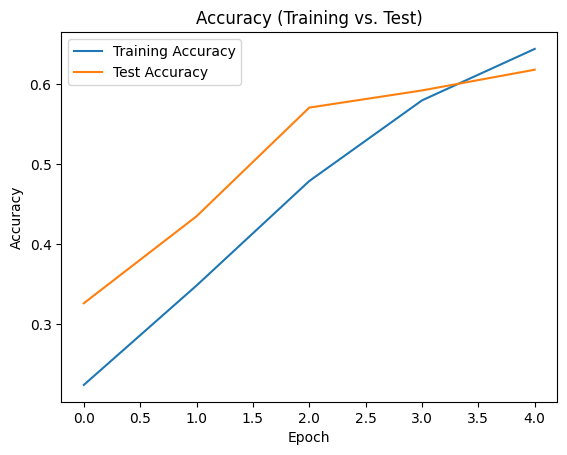

In [21]:
train_and_valid(vgg_model, model_name="vgg16_bn", opt=opt)

### SR Upscaling

In [22]:
########## Training Code ##########
def train_and_valid(vgg_model, sr_model, model_name:str, opt:dict) :
  # Load Dataset
  transform = transforms.Compose([transforms.ToTensor()]) # [0,255] → [0,1] Normalization

  # Download Fashion MNIST Dataset
  train_dataset = datasets.CIFAR10("data/", train=True, transform=transform, download=True)
  test_dataset = datasets.CIFAR10("data/", train=False, transform=transform, download=True)

  # Fix Seed
  fix_seed(opt["seed"])

  # Create DataLoader
  train_loader = DataLoader(train_dataset, batch_size=opt["batch_size"], shuffle=True, num_workers=2, drop_last=True)
  test_loader = DataLoader(test_dataset, batch_size=opt["batch_size"], shuffle=False, num_workers=2)

  # Check Device
  device = "cuda" if opt["cuda"] else "cpu"
  print(f"Current Device : {device}")

  # Fix Seed
  fix_seed(opt["seed"])

  # Create Model Instance
  model = vgg_model.to(device)

  # Create Optimizer Instance
  optimizer = optim.SGD(model.parameters(), lr=opt["lr"])

  # Create Loss Instance
  criterion = nn.CrossEntropyLoss()

  # Create Metric Instance
  metric = Accuracy("multiclass", num_classes=opt["num_classes"]).to(device)

  # Create AverageMeter Instance
  train_loss, train_acc = AverageMeter(), AverageMeter()
  test_loss, test_acc = AverageMeter(), AverageMeter()

  # Create List Instance
  train_loss_list, train_acc_list = [], []
  test_loss_list, test_acc_list = [], []

  # Create Directory
  ckpt_dir, graph_dir = f"ckpt/{model_name}", f"ckpt/{model_name}"
  makedirs(ckpt_dir, exist_ok=True), makedirs(graph_dir, exist_ok=True)

  # Set Best Accuracy
  best_acc = 0

  # Start Training
  for epoch in range(opt["epochs"]) :
    # Create TQDM Bar Instance
    train_bar = tqdm(train_loader)

    # Reset AverageMeter
    train_loss.reset(), train_acc.reset()

    # Set Training Mode
    model.train()

    # Training Phase
    for data in train_bar :
      img, label = data
      img, label = img.to(device), label.to(device)

      if random.random() < 0.75 :
        img = F.interpolate(img, scale_factor=opt["scale"], mode="bicubic")
      else :
        img = sr_model(img)

      # Update Classifier Weights
      optimizer.zero_grad()
      pred = model(img)
      loss = criterion(pred, label)
      loss.backward()
      optimizer.step()

      # Compute Metric
      acc = metric(pred, label)

      # Update AverageMeter
      train_loss.update(loss.cpu().item()), train_acc.update(acc.cpu().item())

      # Show Training Status
      train_bar.set_description(desc=f"[Train] [{epoch+1}/{opt['epochs']}] < Loss:{train_loss.avg:.4f} | Acc.:{train_acc.avg:.4f} >")

    # Add Training Loss and Accuracy
    train_loss_list.append(train_loss.avg), train_acc_list.append(train_acc.avg)

    # Create TQDM Bar Instance
    test_bar = tqdm(test_loader)

    # Reset AverageMeter
    test_loss.reset(), test_acc.reset()

    # Evaluate Model
    with torch.no_grad() :
      # Set Test Mode
      model.eval()

      for data in test_bar :
        img, label = data
        img, label = img.to(device), label.to(device)

        img = F.interpolate(img, scale_factor=opt["scale"], mode="bicubic")

        # Update Classifier Weights
        pred = model(img)
        loss = criterion(pred, label)

        # Compute Metric
        acc = metric(pred, label)

        # Update AverageMeter
        test_loss.update(loss.cpu().item()), test_acc.update(acc.cpu().item())

        # Show Training Status
        test_bar.set_description(desc=f"[Test] [{epoch+1}/{opt['epochs']}] < Loss:{test_loss.avg:.4f} | Acc.:{test_acc.avg:.4f} >")

    # Add Test Loss and Accuracy
    test_loss_list.append(test_loss.avg), test_acc_list.append(test_acc.avg)

    # Save Network
    if test_acc.avg > best_acc :
        best_acc = test_acc.avg
        torch.save(model.state_dict(), f"{ckpt_dir}/best.pth")
    torch.save(model.state_dict(), f"{ckpt_dir}/latest.pth")

    # Plot Training vs. Test Loss Graph
    plt.clf()
    plt.plot(np.arange(epoch+1), train_loss_list, label="Training Loss")
    plt.plot(np.arange(epoch+1), test_loss_list, label="Test Loss")
    plt.title("Loss (Training vs. Test)")
    plt.xlabel("Epoch"), plt.ylabel("Loss")
    plt.legend(loc="best")
    plt.savefig(f"{graph_dir}/loss.png")

    # Plot Training vs. Test Accuracy Graph
    plt.clf()
    plt.plot(np.arange(epoch+1), train_acc_list, label="Training Accuracy")
    plt.plot(np.arange(epoch+1), test_acc_list, label="Test Accuracy")
    plt.title("Accuracy (Training vs. Test)")
    plt.xlabel("Epoch"), plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.savefig(f"{graph_dir}/accuracy.png")

In [23]:
fix_seed(opt["seed"])

In [24]:
vgg_model = VGG16withBN(opt["img_channels"], opt["width"], opt["num_classes"], opt["p"])

In [25]:
if opt["cuda"] :
  vgg_model = vgg_model.cuda()

Current Device : cuda


[Train] [1/5] < Loss:2.0080 | Acc.:0.2228 >: 100%|██████████| 781/781 [02:45<00:00,  4.71it/s]
[Test] [1/5] < Loss:1.6942 | Acc.:0.3316 >: 100%|██████████| 157/157 [00:02<00:00, 53.83it/s]
[Train] [2/5] < Loss:1.6249 | Acc.:0.3496 >: 100%|██████████| 781/781 [02:48<00:00,  4.63it/s]
[Test] [2/5] < Loss:1.5036 | Acc.:0.4204 >: 100%|██████████| 157/157 [00:02<00:00, 57.11it/s]
[Train] [3/5] < Loss:1.3870 | Acc.:0.4803 >: 100%|██████████| 781/781 [02:46<00:00,  4.70it/s]
[Test] [3/5] < Loss:1.5299 | Acc.:0.4523 >: 100%|██████████| 157/157 [00:03<00:00, 47.65it/s]
[Train] [4/5] < Loss:1.1608 | Acc.:0.5854 >: 100%|██████████| 781/781 [02:48<00:00,  4.62it/s]
[Test] [4/5] < Loss:1.0758 | Acc.:0.6103 >: 100%|██████████| 157/157 [00:02<00:00, 58.46it/s]
[Train] [5/5] < Loss:0.9979 | Acc.:0.6491 >: 100%|██████████| 781/781 [02:43<00:00,  4.77it/s]
[Test] [5/5] < Loss:0.9168 | Acc.:0.6690 >: 100%|██████████| 157/157 [00:03<00:00, 49.27it/s]


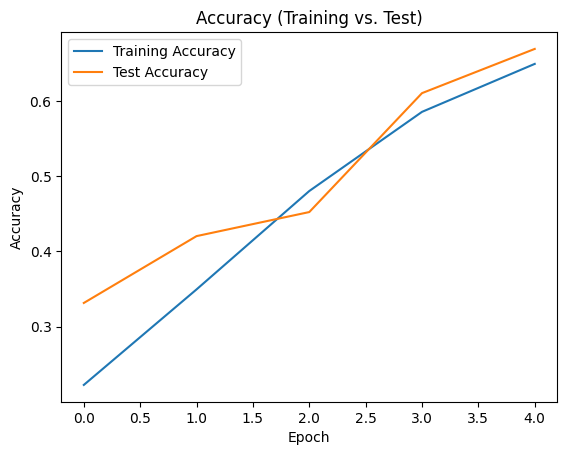

In [26]:
train_and_valid(vgg_model, rcan, model_name="vgg16_bn_rcan", opt=opt)

## 개인실습

### 사전학습된 ResNet18 모델을 불러온 후 CIFAR10에 데이터셋에 대해 전이학습을 진행하세요.
*   CNN 및 Classifier 파트 모두 Unfrozen 상태에서 학습을 진행하세요.
*   CIFAR10 이미지 크기 : 32 x 32 x 3
*   ImageNet 이미지 크기 : 224 x 224 x 3
  *   첫 번째 실습 : Bicubic Interpolation을 통해 224 x 224 x 3으로 업샘플링
  *   두 번째 실습 : Bicubic Interpolation을 통해 56 x 56 x 3으로 업샘플링 후 RCAN x4를 사용하여 224 x 224 x 3으로 업셈플링
*   적절한 데이터 Mixture 비율을 찾아가면서 학습을 진행하세요.









In [30]:
########## Training Code ##########
def transfer_learning_unfrozen(model, img_channels=3, img_size=224, num_classes=2, lr=1e-4, total_epochs=20, seed=42, batch_size=16, src="cats_and_dogs_filtered") :
    # Load Dataset
    train_transform = transforms.Compose([transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                               std=[0.229, 0.224, 0.225])]) # ImageNet의 RGB 통계량
    test_transform = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                              std=[0.229, 0.224, 0.225])]) # ImageNet의 RGB 통계량

    # Create Custom Dataset Instance
    train_dataset = PyTorchCustomDataset(join(src, "train"), train_transform)
    test_dataset = PyTorchCustomDataset(join(src, "validation"), test_transform)

    # Fix Seed
    fix_seed(seed)

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    # Check Device
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Current Device : {device}")

    # Fix Seed
    fix_seed(seed)

    # Unfreeze CNN Backbone
    for param in model.parameters() :
      param.requires_grad = True

    # Replace Linear Layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes) # Customize Classifier

    # Assign Device
    model = model.to(device)

    # Summarize Model
    summary(model, (img_channels, img_size, img_size))

    # Create Optimizer Instance
    optimizer = optim.SGD(model.parameters(), lr=lr)

    # Create Loss Instance
    criterion = nn.CrossEntropyLoss()

    # Create Metric Instance
    metric = Accuracy("multiclass", num_classes=num_classes).to(device)

    # Create AverageMeter Instance
    train_loss, train_acc = AverageMeter(), AverageMeter()
    test_loss, test_acc = AverageMeter(), AverageMeter()

    # Create List Instance
    train_loss_list, train_acc_list = [], []
    test_loss_list, test_acc_list = [], []

    # Create Directory
    ckpt_dir, graph_dir = "ckpt/backbone_unfrozen", "result/backbone_unfrozen"
    makedirs(ckpt_dir, exist_ok=True), makedirs(graph_dir, exist_ok=True)

    # Set Best Accuracy
    best_acc = 0

    # Start Training
    for epoch in range(total_epochs) :
      # Create TQDM Bar Instance
      train_bar = tqdm(train_loader)

      # Reset AverageMeter
      train_loss.reset(), train_acc.reset()

      # Set Training Mode
      model.train()

      # Training Phase
      for data in train_bar :
        img, label = data
        img, label = img.to(device), label.to(device)

        # 해당 파트에 코드를 넣어 이미지 해상도를 변경하세요.
        img = F.resize(img, [img_size, img_size], interpolation=transforms.InterpolationMode.BICUBIC)

        # Update Classifier Weights
        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred, label)
        loss.backward()
        optimizer.step()

        # Compute Metric
        acc = metric(pred, label)

        # Update AverageMeter
        train_loss.update(loss.cpu().item()), train_acc.update(acc.cpu().item())

        # Show Training Status
        train_bar.set_description(desc=f"[Train] [{epoch+1}/{total_epochs}] < Loss:{train_loss.avg:.4f} | Acc.:{train_acc.avg:.4f} >")

      # Add Training Loss and Accuracy
      train_loss_list.append(train_loss.avg), train_acc_list.append(train_acc.avg)

      # Create TQDM Bar Instance
      test_bar = tqdm(test_loader)

      # Reset AverageMeter
      test_loss.reset(), test_acc.reset()

      # Evaluate Model
      with torch.no_grad() :
        # Set Test Mode
        model.eval()

        for data in test_bar :
          img, label = data
          img, label = img.to(device), label.to(device)

          # 해당 파트에 코드를 넣어 이미지 해상도를 변경하세요.
          img = F.resize(img, [img_size, img_size], interpolation=transforms.InterpolationMode.BICUBIC)

          # Update Classifier Weights
          pred = model(img)
          loss = criterion(pred, label)

          # Compute Metric
          acc = metric(pred, label)

          # Update AverageMeter
          test_loss.update(loss.cpu().item()), test_acc.update(acc.cpu().item())

          # Show Training Status
          test_bar.set_description(desc=f"[Test] [{epoch+1}/{total_epochs}] < Loss:{test_loss.avg:.4f} | Acc.:{test_acc.avg:.4f} >")

      # Add Test Loss and Accuracy
      test_loss_list.append(test_loss.avg), test_acc_list.append(test_acc.avg)

      # Save Network
      if test_acc.avg > best_acc :
        best_acc = test_acc.avg
        torch.save(model.state_dict(), f"{ckpt_dir}/best.pth")
      torch.save(model.state_dict(), f"{ckpt_dir}/latest.pth")

      # Plot Training vs. Test Loss Graph
      plt.clf()
      plt.plot(np.arange(epoch+1), train_loss_list, label="Training Loss")
      plt.plot(np.arange(epoch+1), test_loss_list, label="Test Loss")
      plt.title("Loss (Training vs. Test)")
      plt.xlabel("Epoch"), plt.ylabel("Loss")
      plt.legend(loc="best")
      plt.savefig(f"{graph_dir}/loss.png")

      # Plot Training vs. Test Accuracy Graph
      plt.clf()
      plt.plot(np.arange(epoch+1), train_acc_list, label="Training Accuracy")
      plt.plot(np.arange(epoch+1), test_acc_list, label="Test Accuracy")
      plt.title("Accuracy (Training vs. Test)")
      plt.xlabel("Epoch"), plt.ylabel("Accuracy")
      plt.legend(loc="best")
      plt.savefig(f"{graph_dir}/accuracy.png")

In [32]:
img = torch.randn(1, 3, 32, 32)

# 원하는 타겟 크기
img_size = 224

# Bicubic Resize
img_resized = F.resize(img, [img_size, img_size], interpolation=InterpolationMode.BICUBIC)

print(f"Before: {img.shape}")   # torch.Size([1, 3, 32, 32])
print(f"After : {img_resized.shape}")   # torch.Size([1, 3, 224, 224])

Before: torch.Size([1, 3, 32, 32])
After : torch.Size([1, 3, 224, 224])


In [40]:
# RCAN 불러오기
from torchsr.models import rcan

# RCAN 인스턴스 (x4 업샘플링)
scale_factor = 4  # or 2, 3
rcan = rcan(scale=scale_factor, pretrained=True)

rcan = rcan.cuda()
rcan.eval()

RCAN(
  (sub_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (add_mean): MeanShift(3, 3, kernel_size=(1, 1), stride=(1, 1))
  (head): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (body): Sequential(
    (0): ResidualGroup(
      (body): Sequential(
        (0): RCAB(
          (body): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU(inplace=True)
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): CALayer(
              (avg_pool): AdaptiveAvgPool2d(output_size=1)
              (conv_du): Sequential(
                (0): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
                (1): ReLU(inplace=True)
                (2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
                (3): Sigmoid()
              )
            )
          )
        )
        (1): RCAB(
          (body): Sequential(
       

In [46]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as F

class CIFAR10_RCANDataset(Dataset):
    def __init__(self, root, train=True, transform=None, scale=4):
        self.base = datasets.CIFAR10(root=root, train=train, download=True)
        self.transform = transform
        self.scale = scale
        self.rcan = rcan  # 기존에 불러온 RCAN 사용
        self.rcan.eval()

    def __getitem__(self, idx):
        img, label = self.base[idx]

        # PIL → Tensor
        img = transforms.ToTensor()(img)

        # Bicubic Resize 56×56
        img = F.resize(img, [56, 56], interpolation=InterpolationMode.BICUBIC)

        # RCAN x4 → 224×224
        with torch.no_grad():
            img = img.unsqueeze(0).to(next(self.rcan.parameters()).device)  # [1, C, H, W]
            img = self.rcan(img)
            img = img.squeeze(0)

        if self.transform:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.base)

# ✅ 기존 train_dataset → 교체
train_dataset = CIFAR10_RCANDataset(root="data", train=True)
test_dataset = CIFAR10_RCANDataset(root="data", train=False)

print(f"Train len: {len(train_dataset)}, Test len: {len(test_dataset)}")
# ------------------------------------------


Train len: 50000, Test len: 10000


In [47]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [48]:
for img, label in train_loader:
    print(img.shape)  # torch.Size([16, 3, 224, 224]) 나와야 정상!
    break

torch.Size([16, 3, 224, 224])
